In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [26]:
from waterfall.WatermarkerBase import Watermarker
from waterfall.watermark import PROMPT, PRE_PARAPHRASED
import torch
from typing import List
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm import tqdm
from token_tree_generator import expand_, watermarker, TokenDecode, config
from transformers.cache_utils import DynamicCache

In [3]:
# watermarker = Watermarker(model = 'meta-llama/Meta-Llama-3.1-8B-Instruct', device="auto")

In [4]:
T_o = "The boiling point of water is 100 degrees Celsius."
prompt = watermarker.format_prompt(T_o, PROMPT, PRE_PARAPHRASED)
input_ids = watermarker.tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=False)

In [5]:
def single_pass(input_ids, top_k = 4):
    with torch.no_grad():
        output = watermarker.model(
            input_ids = input_ids.to(watermarker.model.device),
            attention_mask = torch.ones_like(input_ids)
            ).cpu()
    return [(idx, prob) for prob, idx in zip(*torch.nn.functional.softmax(output.logits[...,-1,:].squeeze(), dim=-1).topk(k=top_k, dim=0))]

In [6]:
def expand(input_ids, remainder_tokens : int, top_k = 4, threshold = 0.01) -> List:
    if remainder_tokens <= 0:
        return []
    res = []
    pass_results = single_pass(input_ids, top_k = top_k)
    for i, (idx, prob) in enumerate(pass_results):
        if prob <= threshold:
            continue
        new_input_ids = torch.cat([input_ids.clone(), idx.view(1,1)], dim=-1)
        res.append((watermarker.tokenizer.decode(idx), prob.item(), expand(new_input_ids, remainder_tokens-1, top_k = top_k)))
    return res

In [7]:
def single_pass_(input_ids, top_k = 4):
    with torch.no_grad():
        output = watermarker.model(
            input_ids = input_ids.to(watermarker.model.device),
            attention_mask = torch.ones_like(input_ids)
            ).logits[...,-1,:].cpu()
    return [tuple(zip(idx, prob)) for prob, idx in zip(*torch.nn.functional.softmax(output, dim=-1).topk(k=top_k, dim=1))]

In [8]:
# def expand_(input_ids, prev_results, remainder_tokens : int, top_k = 4, threshold = 0.01, bar=None) -> List:
#     if remainder_tokens <= 0:
#         if bar is not None:
#             bar.update(1)
#         return []
#     idxs = [i[0] for i in prev_results if i[1] > threshold]
#     prev_results_ = [i for i in prev_results if i[1] > threshold]
#     if bar is not None:
#         bar.total -= (len(prev_results) - len(prev_results_)) * (top_k ** (remainder_tokens - 1))
#     idxs = torch.stack(idxs)
#     new_input_ids = torch.cat([input_ids.repeat(idxs.shape[0],1), idxs.unsqueeze(1)], dim=-1)
#     pass_results = single_pass_(new_input_ids, top_k = top_k)
#     res = []
#     for (idx, prob), result, new_input_id in zip(prev_results_, pass_results, new_input_ids):
#         if idx == watermarker.tokenizer.eos_token_id:
#             res.append((watermarker.tokenizer.decode(idx), prob.item(), []))
#             if bar is not None:
#                 bar.total -= top_k ** (remainder_tokens - 1)
#             continue
#         res.append((watermarker.tokenizer.decode(idx), prob.item(), (new_input_id, result, remainder_tokens-1, top_k, threshold, bar)))
#     if bar is not None:
#         bar.refresh()
#     return res

In [9]:
# depth = 15
# top_k = 3
# bar = tqdm(total=top_k ** (depth - 1), desc="Expanding tokens")
# expansion = expand_(input_ids[...,:-1], [(input_ids[0,-1], torch.tensor(1.0))], depth, top_k = top_k, threshold = 0.05, bar = bar)
# bar.close()

In [10]:
# def build_graph(tree, G=None, parent=None, counter=[0]):
#     if G is None:
#         G = nx.DiGraph()
#     key, val, children = tree

#     # unique ID
#     node_id = counter[0]
#     counter[0] += 1

#     # label to display
#     label = f"{key}\n{val:.2f}" if val is not None else str(key)

#     G.add_node(node_id, label=label)

#     if parent is not None:
#         G.add_edge(parent, node_id)

#     for child in children:
#         build_graph(child, G, node_id, counter)

#     return G, node_id  # return both graph and root node id


# def hierarchy_pos(G, root, width=1.0, xcenter=0, pos=None, level=0):
#     """Recursive left-to-right hierarchical layout."""
#     if pos is None:
#         pos = {}
#     children = list(G.successors(root))
#     if not children:
#         pos[root] = (level, xcenter)
#     else:
#         dx = width / len(children)
#         nextx = xcenter - width/2 - dx/2
#         pos[root] = (level, xcenter)
#         for child in children[::-1]:
#             nextx += dx
#             pos = hierarchy_pos(G, child, width=dx, 
#                                 xcenter=nextx, pos=pos, level=level+1)
#     return pos

# # tree = ("root", None, expansion)
# tree = expansion[0]
# # Build graph and get root node
# # G, root = build_graph(tree)
# tree = compress_tree(tree)
# G, root = build_graph(tree)

# # Layout positions
# pos = hierarchy_pos(G, root)

# # Get labels from node attributes
# labels = nx.get_node_attributes(G, "label")

# # Draw
# plt.figure(figsize=(8,100))
# nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000, 
#         node_color="lightblue", arrows=True, font_size=10, font_weight="bold")
# plt.show()


In [11]:
from manim import Text, UP, DOWN, LEFT, RIGHT
import numpy as np
import matplotlib.pyplot as plt

-0.012892119897959181 -0.9999984801020411


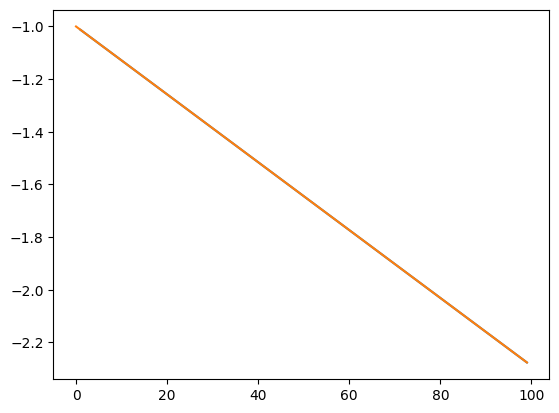

In [12]:
tmp = []
for i in range(1,100):
    a = Text("A", font_size=i, should_center=False)
    tmp.append(a.get_bottom()[1])
m = (tmp[-1] - tmp[0])/(len(tmp)-1)
c = tmp[0] - m
print(m, c)
# c = -20
plt.plot(np.arange(1,100), tmp)
plt.plot(np.arange(100), m * np.arange(100) + c)

In [13]:
font_size = 24
a = Text("a", font_size=font_size, should_center=False)
y_offset = (m * font_size + c - a.get_center()[1])
# y_offset = m * font_size + c
a.next_to(np.array([1, 2, 0]), RIGHT, buff=0.2)
a.shift(DOWN * (y_offset))
print("___")
b = Text("Boiling", font_size=font_size, should_center=False)
y_offset = (m * font_size + c - b.get_center()[1])
# y_offset = m * font_size + c
b.next_to(np.array([1, 2, 0]), RIGHT, buff=0.2)
b.shift(DOWN * (y_offset))

print(a.get_bottom()[1], a.get_top()[1], b.get_bottom()[1], b.get_top()[1])

___
1.9952980076530613 2.1781105076530616 1.9257667576530615 2.2531105076530618


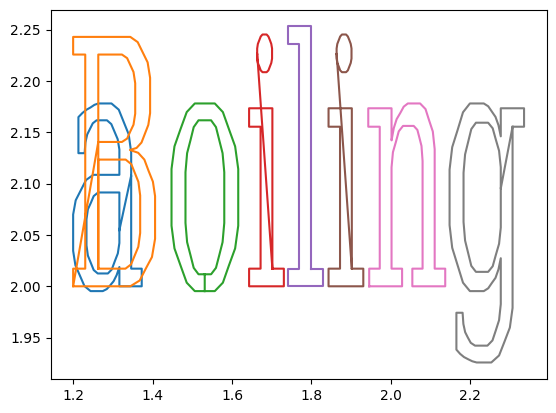

In [14]:
for i in a:
    plt.plot(i.points[:,0], i.points[:,1])
for i in b:
    plt.plot(i.points[:,0], i.points[:,1])

In [43]:
depth = 25
top_k = 5
tree = expand_(input_ids, [(input_ids[0,-1], torch.tensor(1.0))], depth, top_k = top_k, threshold = 0.01, bar = None, past_key_values=None)[0]

In [ ]:
scene = TokenDecode(watermarker, tree=tree, font_size=24, seed=42, top_k=top_k)
scene.render()
tree = scene.tree

1


[08/22/25 14:41:19] INFO     Animation 0 : Partial movie file written in                   ]8;id=441483;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=487642;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/1296412373_231405789_22                         
                             3132457.mp4'                                                                          

2


[08/22/25 14:41:20] INFO     Animation 1 : Partial movie file written in                   ]8;id=920371;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=405669;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3956945567_37                         
                             62947829.mp4'                                                                         

3


                    INFO     Animation 2 : Partial movie file written in                   ]8;id=256285;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=673043;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1792097190_27                         
                             56829128.mp4'                                                                         

                    INFO     Animation 3 : Partial movie file written in                   ]8;id=27534;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=890738;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_36                         
                             85537107.mp4'                                                                         

4
5


[08/22/25 14:41:21] INFO     Animation 4 : Partial movie file written in                   ]8;id=589439;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=464607;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3765867727_91                         
                             9343945.mp4'                                                                          

                    INFO     Animation 5 : Partial movie file written in                   ]8;id=105845;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=742954;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_641209743_159                         
                             5121890.mp4'                                                                          

[08/22/25 14:41:22] INFO     Animation 6 : Partial movie file written in                   ]8;id=751404;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=236799;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_17                         
                             46875405.mp4'                                                                         

                    INFO     Animation 7 : Partial movie file written in                   ]8;id=385570;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=546266;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_338924505_414                         
                             4281293.mp4'                                                                          

[08/22/25 14:41:23] INFO     Animation 8 : Partial movie file written in                   ]8;id=21545;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=681662;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_20                         
                             64022304.mp4'                                                                         

                    INFO     Animation 9 : Partial movie file written in                   ]8;id=769955;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=305749;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1936146677_35                         
                             39419389.mp4'                                                                         

6


[08/22/25 14:41:24] INFO     Animation 10 : Partial movie file written in                  ]8;id=981132;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=515269;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2488464307_30                         
                             74247369.mp4'                                                                         

7


                    INFO     Animation 11 : Partial movie file written in                  ]8;id=304096;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=985038;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2492439871_29                         
                             85315955.mp4'                                                                         

                    INFO     Animation 12 : Partial movie file written in                  ]8;id=455418;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=983811;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2574473371_31                         
                             3073079.mp4'                                                                          

8
9
10


[08/22/25 14:41:25] INFO     Animation 13 : Partial movie file written in                  ]8;id=302811;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=360370;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2771850580_33                         
                             23332632.mp4'                                                                         

                    INFO     Animation 14 : Partial movie file written in                  ]8;id=615494;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=754907;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2135015534_61                         
                             257058.mp4'                                                                           

[08/22/25 14:41:26] INFO     Animation 15 : Partial movie file written in                  ]8;id=742923;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=328140;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4079250704_31                         
                             06485374.mp4'                                                                         

11


                    INFO     Animation 16 : Partial movie file written in                  ]8;id=251538;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=872922;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_785595387_120                         
                             9871727.mp4'                                                                          

12


                    INFO     Animation 17 : Partial movie file written in                  ]8;id=788506;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=54868;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3325140598_18                         
                             14444762.mp4'                                                                         

                    INFO     Animation 18 : Partial movie file written in                  ]8;id=939426;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=545281;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_18                         
                             33682458.mp4'                                                                         

1


[08/22/25 14:41:27] INFO     Animation 19 : Partial movie file written in                  ]8;id=841387;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=302501;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_344172017_205                         
                             3872308.mp4'                                                                          

2


                    INFO     Animation 20 : Partial movie file written in                  ]8;id=543307;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=971983;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2540449513_24                         
                             1464060.mp4'                                                                          

3


[08/22/25 14:41:28] INFO     Animation 21 : Partial movie file written in                  ]8;id=32014;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=100101;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2748071562_11                         
                             2048871.mp4'                                                                          

                    INFO     Animation 22 : Partial movie file written in                  ]8;id=902944;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=817635;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_22                         
                             50113103.mp4'                                                                         

4
5


[08/22/25 14:41:29] INFO     Animation 23 : Partial movie file written in                  ]8;id=943536;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=42080;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3874622363_16                         
                             65820903.mp4'                                                                         

                    INFO     Animation 24 : Partial movie file written in                  ]8;id=792619;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=904152;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3457024367_86                         
                             354868.mp4'                                                                           

                    INFO     Animation 25 : Partial movie file written in                  ]8;id=120130;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=69097;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_38                         
                             95849157.mp4'                                                                         

[08/22/25 14:41:30] INFO     Animation 26 : Partial movie file written in                  ]8;id=365959;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=548137;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_173112607_133                         
                             0605328.mp4'                                                                          

[08/22/25 14:41:31] INFO     Animation 27 : Partial movie file written in                  ]8;id=480395;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=58869;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_13                         
                             77381255.mp4'                                                                         

                    INFO     Animation 28 : Partial movie file written in                  ]8;id=532118;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=778544;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_952277296_102                         
                             2768617.mp4'                                                                          

6


[08/22/25 14:41:32] INFO     Animation 29 : Partial movie file written in                  ]8;id=208459;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=524351;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_251054259_103                         
                             6553558.mp4'                                                                          

7


                    INFO     Animation 30 : Partial movie file written in                  ]8;id=259377;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=220232;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4074829365_19                         
                             77965559.mp4'                                                                         

[08/22/25 14:41:33] INFO     Animation 31 : Partial movie file written in                  ]8;id=180813;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=692932;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2574473371_16                         
                             27489595.mp4'                                                                         

8
9
10


                    INFO     Animation 32 : Partial movie file written in                  ]8;id=924074;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=981923;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1207837428_23                         
                             9780168.mp4'                                                                          

[08/22/25 14:41:34] INFO     Animation 33 : Partial movie file written in                  ]8;id=569141;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=219549;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2585638981_33                         
                             73578837.mp4'                                                                         

                    INFO     Animation 34 : Partial movie file written in                  ]8;id=262328;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=882146;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4079250704_20                         
                             06206492.mp4'                                                                         

11


[08/22/25 14:41:35] INFO     Animation 35 : Partial movie file written in                  ]8;id=658125;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=634826;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_247124308_792                         
                             119479.mp4'                                                                           

12


                    INFO     Animation 36 : Partial movie file written in                  ]8;id=507892;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=784066;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3009603636_20                         
                             02135708.mp4'                                                                         

                    INFO     Animation 37 : Partial movie file written in                  ]8;id=898954;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=903181;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_42                         
                             78817372.mp4'                                                                         

1


[08/22/25 14:41:36] INFO     Animation 38 : Partial movie file written in                  ]8;id=401808;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=955324;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2848136543_32                         
                             68549594.mp4'                                                                         

2


                    INFO     Animation 39 : Partial movie file written in                  ]8;id=313184;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=102838;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4013330873_76                         
                             3698909.mp4'                                                                          

3


                    INFO     Animation 40 : Partial movie file written in                  ]8;id=813541;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=26613;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3766066931_21                         
                             16460125.mp4'                                                                         

                    INFO     Animation 41 : Partial movie file written in                  ]8;id=719753;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=121651;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_30                         
                             14940200.mp4'                                                                         

4
5


[08/22/25 14:41:37] INFO     Animation 42 : Partial movie file written in                  ]8;id=119288;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=594601;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4167841892_11                         
                             02880464.mp4'                                                                         

                    INFO     Animation 43 : Partial movie file written in                  ]8;id=248376;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=277056;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1703743682_13                         
                             14127776.mp4'                                                                         

                    INFO     Animation 44 : Partial movie file written in                  ]8;id=734123;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=952944;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_36                         
                             75581876.mp4'                                                                         

[08/22/25 14:41:38] INFO     Animation 45 : Partial movie file written in                  ]8;id=928469;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=670515;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2772712687_14                         
                             62828614.mp4'                                                                         

                    INFO     Animation 46 : Partial movie file written in                  ]8;id=588872;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=114859;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_22                         
                             6459297.mp4'                                                                          

[08/22/25 14:41:39] INFO     Animation 47 : Partial movie file written in                  ]8;id=869512;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=620545;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_697467191_298                         
                             7925533.mp4'                                                                          

6


                    INFO     Animation 48 : Partial movie file written in                  ]8;id=343154;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=937117;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3756788022_99                         
                             026787.mp4'                                                                           

7


                    INFO     Animation 49 : Partial movie file written in                  ]8;id=17817;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=668683;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1751473557_13                         
                             28895560.mp4'                                                                         

[08/22/25 14:41:40] INFO     Animation 50 : Partial movie file written in                  ]8;id=457627;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=99840;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2574473371_22                         
                             07055508.mp4'                                                                         

8
9
10


                    INFO     Animation 51 : Partial movie file written in                  ]8;id=617797;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=548372;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_27610430_2519                         
                             132311.mp4'                                                                           

[08/22/25 14:41:41] INFO     Animation 52 : Partial movie file written in                  ]8;id=518982;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=43478;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3836955916_42                         
                             49574494.mp4'                                                                         

                    INFO     Animation 53 : Partial movie file written in                  ]8;id=40755;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=908060;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4079250704_93                         
                             0927239.mp4'                                                                          

11


                    INFO     Animation 54 : Partial movie file written in                  ]8;id=894011;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=423930;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1810363842_41                         
                             12884606.mp4'                                                                         

12


[08/22/25 14:41:42] INFO     Animation 55 : Partial movie file written in                  ]8;id=232364;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=553987;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1417248438_56                         
                             9834818.mp4'                                                                          

                    INFO     Animation 56 : Partial movie file written in                  ]8;id=413034;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=983970;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_884610985_143                         
                             8455078.mp4'                                                                          

1


[08/22/25 14:41:43] INFO     Animation 57 : Partial movie file written in                  ]8;id=65909;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=585901;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3150210723_27                         
                             65404171.mp4'                                                                         

2


                    INFO     Animation 58 : Partial movie file written in                  ]8;id=831188;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=557440;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3874623963_25                         
                             33379467.mp4'                                                                         

3


                    INFO     Animation 59 : Partial movie file written in                  ]8;id=493821;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=702328;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3092504692_36                         
                             352482.mp4'                                                                           

[08/22/25 14:41:44] INFO     Animation 60 : Partial movie file written in                  ]8;id=667852;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=5883;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3768012392_39                         
                             87295876.mp4'                                                                         

4
5


                    INFO     Animation 61 : Partial movie file written in                  ]8;id=544443;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=871135;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1917002346_38                         
                             18417052.mp4'                                                                         

[08/22/25 14:41:45] INFO     Animation 62 : Partial movie file written in                  ]8;id=857578;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=397861;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2208621992_45                         
                             6362985.mp4'                                                                          

                    INFO     Animation 63 : Partial movie file written in                  ]8;id=826608;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=877464;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_38                         
                             43271625.mp4'                                                                         

[08/22/25 14:41:46] INFO     Animation 64 : Partial movie file written in                  ]8;id=986647;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=638218;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2143654325_25                         
                             40456166.mp4'                                                                         

                    INFO     Animation 65 : Partial movie file written in                  ]8;id=619091;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=875073;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_22                         
                             88416496.mp4'                                                                         

[08/22/25 14:41:47] INFO     Animation 66 : Partial movie file written in                  ]8;id=680170;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=482468;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1712411744_34                         
                             19697929.mp4'                                                                         

6


                    INFO     Animation 67 : Partial movie file written in                  ]8;id=757161;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=384784;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3101043310_28                         
                             83113895.mp4'                                                                         

7


[08/22/25 14:41:48] INFO     Animation 68 : Partial movie file written in                  ]8;id=525749;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=813441;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2342763498_29                         
                             31403466.mp4'                                                                         

                    INFO     Animation 69 : Partial movie file written in                  ]8;id=469977;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=652450;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2574473371_20                         
                             77514574.mp4'                                                                         

8
9
10


[08/22/25 14:41:49] INFO     Animation 70 : Partial movie file written in                  ]8;id=401697;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=159896;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_842031091_328                         
                             0744333.mp4'                                                                          

                    INFO     Animation 71 : Partial movie file written in                  ]8;id=170950;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=896483;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3065180156_41                         
                             992944.mp4'                                                                           

[08/22/25 14:41:50] INFO     Animation 72 : Partial movie file written in                  ]8;id=606508;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=643498;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4079250704_38                         
                             73594605.mp4'                                                                         

11


                    INFO     Animation 73 : Partial movie file written in                  ]8;id=915552;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=141062;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_663979975_407                         
                             6278620.mp4'                                                                          

12


                    INFO     Animation 74 : Partial movie file written in                  ]8;id=781465;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=641947;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2989131191_13                         
                             26826120.mp4'                                                                         

                    INFO     Animation 75 : Partial movie file written in                  ]8;id=166300;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=978504;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_72                         
                             7415682.mp4'                                                                          

1


[08/22/25 14:41:51] INFO     Animation 76 : Partial movie file written in                  ]8;id=402295;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=486863;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1190860007_42                         
                             87846350.mp4'                                                                         

2


[08/22/25 14:41:52] INFO     Animation 77 : Partial movie file written in                  ]8;id=659703;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=69385;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2889171435_24                         
                             15539838.mp4'                                                                         

3


[08/22/25 14:41:53] INFO     Animation 78 : Partial movie file written in                  ]8;id=720840;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=382931;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_120647876_129                         
                             9496494.mp4'                                                                          

                    INFO     Animation 79 : Partial movie file written in                  ]8;id=739859;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=368022;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3673774721_42                         
                             28669950.mp4'                                                                         

4
5


[08/22/25 14:41:54] INFO     Animation 80 : Partial movie file written in                  ]8;id=16189;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=413980;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2902239212_20                         
                             69579211.mp4'                                                                         

                    INFO     Animation 81 : Partial movie file written in                  ]8;id=227248;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=977404;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1363478107_26                         
                             78306365.mp4'                                                                         

[08/22/25 14:41:55] INFO     Animation 82 : Partial movie file written in                  ]8;id=945119;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=487961;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_24                         
                             83316590.mp4'                                                                         

                    INFO     Animation 83 : Partial movie file written in                  ]8;id=782246;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=806089;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3313417098_27                         
                             21168561.mp4'                                                                         

[08/22/25 14:41:56] INFO     Animation 84 : Partial movie file written in                  ]8;id=226412;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=884244;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_28                         
                             48575858.mp4'                                                                         

[08/22/25 14:41:57] INFO     Animation 85 : Partial movie file written in                  ]8;id=407605;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=443732;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_763543007_403                         
                             9820350.mp4'                                                                          

6


                    INFO     Animation 86 : Partial movie file written in                  ]8;id=849833;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=849192;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_362721098_933                         
                             418563.mp4'                                                                           

7


[08/22/25 14:41:58] INFO     Animation 87 : Partial movie file written in                  ]8;id=326713;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=148094;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_136138328_421                         
                             4704325.mp4'                                                                          

                    INFO     Animation 88 : Partial movie file written in                  ]8;id=296858;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=151544;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2574473371_19                         
                             89860815.mp4'                                                                         

8
9
10


[08/22/25 14:41:59] INFO     Animation 89 : Partial movie file written in                  ]8;id=347193;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=745249;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1561056448_21                         
                             4618284.mp4'                                                                          

[08/22/25 14:42:00] INFO     Animation 90 : Partial movie file written in                  ]8;id=269444;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=35536;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3061551484_38                         
                             50985546.mp4'                                                                         

                    INFO     Animation 91 : Partial movie file written in                  ]8;id=272961;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=169196;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4079250704_19                         
                             49873039.mp4'                                                                         

11


                    INFO     Animation 92 : Partial movie file written in                  ]8;id=717348;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=74973;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_62651458_3430                         
                             477718.mp4'                                                                           

12


[08/22/25 14:42:01] INFO     Animation 93 : Partial movie file written in                  ]8;id=392862;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=539043;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3820945920_41                         
                             93929688.mp4'                                                                         

                    INFO     Animation 94 : Partial movie file written in                  ]8;id=211991;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=648618;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_27                         
                             59923648.mp4'                                                                         

1


                    INFO     Animation 95 : Partial movie file written in                  ]8;id=309189;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=248182;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3684888914_42                         
                             45904441.mp4'                                                                         

2


[08/22/25 14:42:02] INFO     Animation 96 : Partial movie file written in                  ]8;id=757484;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=669816;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1016544603_39                         
                             55836604.mp4'                                                                         

3


                    INFO     Animation 97 : Partial movie file written in                  ]8;id=518017;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=545172;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_28                         
                             37864156.mp4'                                                                         

4
5


[08/22/25 14:42:03] INFO     Animation 98 : Partial movie file written in                  ]8;id=456183;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=207103;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2391871269_63                         
                             2383416.mp4'                                                                          

                    INFO     Animation 99 : Partial movie file written in                  ]8;id=843794;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=340576;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3429913595_32                         
                             17111133.mp4'                                                                         

                    INFO     Animation 100 : Partial movie file written in                 ]8;id=197689;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=927723;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3768012392_34                         
                             12564158.mp4'                                                                         

[08/22/25 14:42:04] INFO     Animation 101 : Partial movie file written in                 ]8;id=253978;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=722815;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_412425600_111                         
                             8812061.mp4'                                                                          

                    INFO     Animation 102 : Partial movie file written in                 ]8;id=478130;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=831488;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_16                         
                             25812268.mp4'                                                                         

                    INFO     Animation 103 : Partial movie file written in                 ]8;id=887995;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=418871;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3007098329_19                         
                             34054750.mp4'                                                                         

6


[08/22/25 14:42:05] INFO     Animation 104 : Partial movie file written in                 ]8;id=214790;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=998893;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_401533421_143                         
                             7579336.mp4'                                                                          

7


                    INFO     Animation 105 : Partial movie file written in                 ]8;id=24215;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=73646;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1263255800_39                         
                             18499787.mp4'                                                                         

                    INFO     Animation 106 : Partial movie file written in                 ]8;id=88022;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=272408;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_2574473371_24                         
                             92806327.mp4'                                                                         

8
9
10


[08/22/25 14:42:06] INFO     Animation 107 : Partial movie file written in                 ]8;id=302468;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=478051;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4261797736_33                         
                             73666744.mp4'                                                                         

[08/22/25 14:42:07] INFO     Animation 108 : Partial movie file written in                 ]8;id=139588;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=830750;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_3937334353_20                         
                             45890617.mp4'                                                                         

                    INFO     Animation 109 : Partial movie file written in                 ]8;id=970268;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=173836;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4079250704_73                         
                             4376745.mp4'                                                                          

11


                    INFO     Animation 110 : Partial movie file written in                 ]8;id=850706;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=772754;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1404621026_34                         
                             37208600.mp4'                                                                         

12


[08/22/25 14:42:08] INFO     Animation 111 : Partial movie file written in                 ]8;id=248770;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=328847;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_4084780734_97                         
                             3165386.mp4'                                                                          

                    INFO     Animation 112 : Partial movie file written in                 ]8;id=604066;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=849231;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#588\588]8;;\
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/partial_movie_files/TokenDecode/269048510_1914722975_23                         
                             67693369.mp4'                                                                         

                    INFO     Combining to Movie file.                                      ]8;id=801875;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=496989;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#739\739]8;;\

[08/22/25 14:42:09] INFO                                                                   ]8;id=852503;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=539698;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#886\886]8;;\
                             File ready at                                                                         
                             '/nfs_home/niuxy/watermark/vllm_pip_waterfall/media/videos/16                         
                             00p15/TokenDecode.mp4'                                                                
                                                                                                                   

                    INFO     The partial movie directory is full (> 100 files). Therefore, ]8;id=334986;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=811023;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene_file_writer.py#856\856]8;;\
                             manim has removed the 114 oldest file(s). You can change this                         
                             behaviour by changing max_files_cached in config.                                     

                    INFO     Rendered TokenDecode                                                      ]8;id=552967;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene.py\scene.py]8;;\:]8;id=843195;file:///home/niuxy/maplecg_nfs/miniconda3/envs/animation/lib/python3.12/site-packages/manim/scene/scene.py#255\255]8;;\
                             Played 113 animations                                                                 